Copyright by Arjun Sarkar Research Group Applied Systems Biology - Head: Prof. Dr. Marc Thilo Figge https://www.leibniz-hki.de/en/applied-systems-biology.html HKI-Center for Systems Biology of Infection Leibniz Institute for Natural Product Research and Infection Biology - Hans Knöll Insitute (HKI) Adolf-Reichwein-Straße 23, 07745 Jena, Germany

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2 as cv
import math

from sklearn import preprocessing
import datetime

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau

from sklearn.model_selection import train_test_split

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"

strategy = tf.distribute.MirroredStrategy(["GPU:0"])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [3]:
df = pd.read_csv('Label_Training.csv')
df.head()

,video_num,image,infection,patient,class_label,image_path
0,1,246.tif,ca,1,0,/asbdata/Arjun/Bloodi/TIFF8/1/246.tif
1,1,094.tif,ca,1,0,/asbdata/Arjun/Bloodi/TIFF8/1/094.tif
2,1,158.tif,ca,1,0,/asbdata/Arjun/Bloodi/TIFF8/1/158.tif
3,1,062.tif,ca,1,0,/asbdata/Arjun/Bloodi/TIFF8/1/062.tif
4,1,174.tif,ca,1,0,/asbdata/Arjun/Bloodi/TIFF8/1/174.tif


In [4]:
test = df[(df['patient']==1)]
test

,video_num,image,infection,patient,class_label,image_path
0,1,246.tif,ca,1,0,/asbdata/Arjun/Bloodi/TIFF8/1/246.tif
1,1,094.tif,ca,1,0,/asbdata/Arjun/Bloodi/TIFF8/1/094.tif
2,1,158.tif,ca,1,0,/asbdata/Arjun/Bloodi/TIFF8/1/158.tif
3,1,062.tif,ca,1,0,/asbdata/Arjun/Bloodi/TIFF8/1/062.tif
4,1,174.tif,ca,1,0,/asbdata/Arjun/Bloodi/TIFF8/1/174.tif
...,...,...,...,...,...,...
775,3,177.tif,mock,1,2,/asbdata/Arjun/Bloodi/TIFF8/3/177.tif
776,3,066.tif,mock,1,2,/asbdata/Arjun/Bloodi/TIFF8/3/066.tif
777,3,042.tif,mock,1,2,/asbdata/Arjun/Bloodi/TIFF8/3/042.tif
778,3,250.tif,mock,1,2,/asbdata/Arjun/Bloodi/TIFF8/3/250.tif


In [5]:
Xtrain = pd.concat([df, test]).drop_duplicates(keep=False)
Xtrain

,video_num,image,infection,patient,class_label,image_path
780,4,246.tif,ca,2,0,/asbdata/Arjun/Bloodi/TIFF8/4/246.tif
781,4,094.tif,ca,2,0,/asbdata/Arjun/Bloodi/TIFF8/4/094.tif
782,4,158.tif,ca,2,0,/asbdata/Arjun/Bloodi/TIFF8/4/158.tif
783,4,062.tif,ca,2,0,/asbdata/Arjun/Bloodi/TIFF8/4/062.tif
784,4,174.tif,ca,2,0,/asbdata/Arjun/Bloodi/TIFF8/4/174.tif
...,...,...,...,...,...,...
7015,35,177.tif,mock,12,2,/asbdata/Arjun/Bloodi/TIFF8/35/177.tif
7016,35,066.tif,mock,12,2,/asbdata/Arjun/Bloodi/TIFF8/35/066.tif
7017,35,042.tif,mock,12,2,/asbdata/Arjun/Bloodi/TIFF8/35/042.tif
7018,35,250.tif,mock,12,2,/asbdata/Arjun/Bloodi/TIFF8/35/250.tif


In [6]:
train, val = train_test_split(Xtrain, test_size=0.2, stratify = Xtrain['class_label'], random_state=42)
train

,video_num,image,infection,patient,class_label,image_path
1322,6,186.tif,mock,2,2,/asbdata/Arjun/Bloodi/TIFF8/6/186.tif
3459,22,178.tif,cg,8,1,/asbdata/Arjun/Bloodi/TIFF8/22/178.tif
3528,22,107.tif,cg,8,1,/asbdata/Arjun/Bloodi/TIFF8/22/107.tif
1668,13,142.tif,ca,5,0,/asbdata/Arjun/Bloodi/TIFF8/13/142.tif
4519,26,197.tif,mock,9,2,/asbdata/Arjun/Bloodi/TIFF8/26/197.tif
...,...,...,...,...,...,...
3011,20,140.tif,mock,7,2,/asbdata/Arjun/Bloodi/TIFF8/20/140.tif
1682,13,189.tif,ca,5,0,/asbdata/Arjun/Bloodi/TIFF8/13/189.tif
6588,34,115.tif,cg,12,1,/asbdata/Arjun/Bloodi/TIFF8/34/115.tif
4264,25,179.tif,cg,9,1,/asbdata/Arjun/Bloodi/TIFF8/25/179.tif


In [7]:
val

,video_num,image,infection,patient,class_label,image_path
5852,31,069.tif,cg,11,1,/asbdata/Arjun/Bloodi/TIFF8/31/069.tif
6462,33,056.tif,ca,12,0,/asbdata/Arjun/Bloodi/TIFF8/33/056.tif
2053,14,233.tif,cg,5,1,/asbdata/Arjun/Bloodi/TIFF8/14/233.tif
3211,21,051.tif,ca,8,0,/asbdata/Arjun/Bloodi/TIFF8/21/051.tif
1706,13,039.tif,ca,5,0,/asbdata/Arjun/Bloodi/TIFF8/13/039.tif
...,...,...,...,...,...,...
3924,24,098.tif,ca,9,0,/asbdata/Arjun/Bloodi/TIFF8/24/098.tif
5908,31,103.tif,cg,11,1,/asbdata/Arjun/Bloodi/TIFF8/31/103.tif
4352,25,072.tif,cg,9,1,/asbdata/Arjun/Bloodi/TIFF8/25/072.tif
3929,24,161.tif,ca,9,0,/asbdata/Arjun/Bloodi/TIFF8/24/161.tif


In [8]:
image_size = 512
batch_size = 16

def get_train_generator(df, x_col, y_cols, shuffle=True, batch_size=batch_size, seed=1, image_size=image_size):

    # normalize images
    image_generator = ImageDataGenerator(preprocessing_function=preprocess_input,
                                        horizontal_flip=True,
                                        vertical_flip=True)
    
    # flow from directory with specified batch size
    # and target image size
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=None,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            target_size=(image_size,image_size),
            shuffle=False,
            seed=seed)
    
    return generator

def get_test_and_valid_generator(valid_df, test_df, x_col, y_cols, batch_size=batch_size, seed=1, image_size=image_size):

    image_generator = ImageDataGenerator(preprocessing_function=preprocess_input)


    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=None,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            target_size = (image_size,image_size),
            shuffle=False,
            seed=seed)
    
    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=None,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            target_size = (image_size,image_size),
            shuffle=False,
            seed=seed)
    
    return valid_generator, test_generator

In [9]:
train_generator = get_train_generator(train, 'image_path', 'class_label')
valid_generator, test_generator= get_test_and_valid_generator(val, test, 'image_path','class_label')

Found 4992 validated image filenames.
Found 1248 validated image filenames.
Found 780 validated image filenames.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


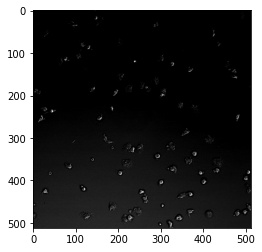

In [10]:
x, y = train_generator.__getitem__(3)
plt.imshow(x[0])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


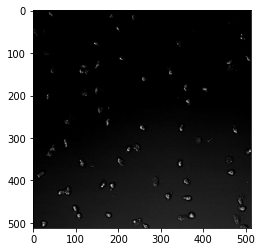

In [11]:
x, y = valid_generator.__getitem__(3)
plt.imshow(x[0])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


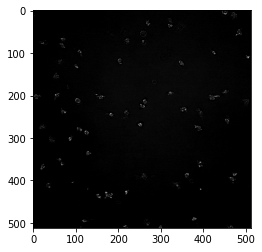

In [12]:
x, y = test_generator.__getitem__(3)
plt.imshow(x[0])
plt.show()

In [13]:
with strategy.scope():
    
    inputs = Input(shape=(image_size,image_size, 3))
    base_model = InceptionV3 (weights = 'imagenet',include_top=False, input_tensor=inputs)

    # add a global spatial average pooling layer
    x = GlobalAveragePooling2D()(base_model.output)

    x = Dense(1024, kernel_regularizer=l2(0.0003),activation='relu')(x)
    x = Dropout(0.5)(x)

    # and a logistic layer
    predictions = Dense(3, activation="softmax")(x)
    
    model = Model(inputs=inputs, outputs=predictions)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(), 
                  loss="sparse_categorical_crossentropy", 
                  metrics=["accuracy"])

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 255, 255, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 255, 255, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

                                                                                                  
 conv2d_10 (Conv2D)             (None, 61, 61, 96)   82944       ['activation_9[0][0]']           
                                                                                                  
 conv2d_11 (Conv2D)             (None, 61, 61, 32)   6144        ['average_pooling2d[0][0]']      
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 61, 61, 64)  192         ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 61, 61, 64)  192         ['conv2d_7[0][0]']               
 rmalization)                                                                                     
          

                                                                  'activation_14[0][0]',          
                                                                  'activation_17[0][0]',          
                                                                  'activation_18[0][0]']          
                                                                                                  
 conv2d_22 (Conv2D)             (None, 61, 61, 64)   18432       ['mixed1[0][0]']                 
                                                                                                  
 batch_normalization_22 (BatchN  (None, 61, 61, 64)  192         ['conv2d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_22 (Activation)     (None, 61, 61, 64)   0           ['batch_normalization_22[0][0]'] 
          

 ormalization)                                                                                    
                                                                                                  
 activation_26 (Activation)     (None, 30, 30, 384)  0           ['batch_normalization_26[0][0]'] 
                                                                                                  
 activation_29 (Activation)     (None, 30, 30, 96)   0           ['batch_normalization_29[0][0]'] 
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 30, 30, 288)  0          ['mixed2[0][0]']                 
                                                                                                  
 mixed3 (Concatenate)           (None, 30, 30, 768)  0           ['activation_26[0][0]',          
                                                                  'activation_29[0][0]',          
          

 activation_39 (Activation)     (None, 30, 30, 192)  0           ['batch_normalization_39[0][0]'] 
                                                                                                  
 mixed4 (Concatenate)           (None, 30, 30, 768)  0           ['activation_30[0][0]',          
                                                                  'activation_33[0][0]',          
                                                                  'activation_38[0][0]',          
                                                                  'activation_39[0][0]']          
                                                                                                  
 conv2d_44 (Conv2D)             (None, 30, 30, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_44 (BatchN  (None, 30, 30, 160)  480        ['conv2d_44[0][0]']              
 ormalizat

                                                                  'activation_49[0][0]']          
                                                                                                  
 conv2d_54 (Conv2D)             (None, 30, 30, 160)  122880      ['mixed5[0][0]']                 
                                                                                                  
 batch_normalization_54 (BatchN  (None, 30, 30, 160)  480        ['conv2d_54[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_54 (Activation)     (None, 30, 30, 160)  0           ['batch_normalization_54[0][0]'] 
                                                                                                  
 conv2d_55 (Conv2D)             (None, 30, 30, 160)  179200      ['activation_54[0][0]']          
          

 ormalization)                                                                                    
                                                                                                  
 activation_64 (Activation)     (None, 30, 30, 192)  0           ['batch_normalization_64[0][0]'] 
                                                                                                  
 conv2d_65 (Conv2D)             (None, 30, 30, 192)  258048      ['activation_64[0][0]']          
                                                                                                  
 batch_normalization_65 (BatchN  (None, 30, 30, 192)  576        ['conv2d_65[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_65 (Activation)     (None, 30, 30, 192)  0           ['batch_normalization_65[0][0]'] 
          

                                                                                                  
 batch_normalization_73 (BatchN  (None, 30, 30, 192)  576        ['conv2d_73[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_73 (Activation)     (None, 30, 30, 192)  0           ['batch_normalization_73[0][0]'] 
                                                                                                  
 conv2d_70 (Conv2D)             (None, 30, 30, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_74 (Conv2D)             (None, 30, 30, 192)  258048      ['activation_73[0][0]']          
                                                                                                  
 batch_nor

 batch_normalization_83 (BatchN  (None, 14, 14, 384)  1152       ['conv2d_83[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_84 (Conv2D)             (None, 14, 14, 192)  245760      ['average_pooling2d_7[0][0]']    
                                                                                                  
 batch_normalization_76 (BatchN  (None, 14, 14, 320)  960        ['conv2d_76[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_78 (Activation)     (None, 14, 14, 384)  0           ['batch_normalization_78[0][0]'] 
                                                                                                  
 activatio

 ormalization)                                                                                    
                                                                                                  
 activation_87 (Activation)     (None, 14, 14, 384)  0           ['batch_normalization_87[0][0]'] 
                                                                                                  
 activation_88 (Activation)     (None, 14, 14, 384)  0           ['batch_normalization_88[0][0]'] 
                                                                                                  
 activation_91 (Activation)     (None, 14, 14, 384)  0           ['batch_normalization_91[0][0]'] 
                                                                                                  
 activation_92 (Activation)     (None, 14, 14, 384)  0           ['batch_normalization_92[0][0]'] 
                                                                                                  
 batch_nor

In [15]:
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)

stopping = EarlyStopping(monitor='val_loss', patience=5)

callbacks = ModelCheckpoint('inception_fullimage_test_1.h5', 
                            monitor='val_loss', save_best_only=True, mode = 'auto')

In [16]:
history = model.fit(train_generator, 
                              validation_data=valid_generator,
                              epochs = 10,
                              callbacks = [callbacks,lr_schedule,stopping])

Epoch 1/10
312/312 [==============================] - 253s 767ms/step - loss: 1.2289 - accuracy: 0.4712 - val_loss: 1.4037 - val_accuracy: 0.5489 - lr: 0.0010
Epoch 2/10
312/312 [==============================] - 236s 756ms/step - loss: 0.5044 - accuracy: 0.8319 - val_loss: 12.4167 - val_accuracy: 0.6098 - lr: 0.0010
Epoch 3/10
312/312 [==============================] - 239s 765ms/step - loss: 0.2580 - accuracy: 0.9265 - val_loss: 0.1231 - val_accuracy: 0.9647 - lr: 0.0010
Epoch 4/10
312/312 [==============================] - 237s 760ms/step - loss: 0.1641 - accuracy: 0.9527 - val_loss: 0.4006 - val_accuracy: 0.9135 - lr: 0.0010
Epoch 5/10
312/312 [==============================] - 235s 755ms/step - loss: 0.1281 - accuracy: 0.9639 - val_loss: 1.8692 - val_accuracy: 0.6619 - lr: 0.0010
Epoch 6/10
312/312 [==============================] - 234s 752ms/step - loss: 0.1133 - accuracy: 0.9724 - val_loss: 0.1277 - val_accuracy: 0.9559 - lr: 0.0010
Epoch 7/10
312/312 [=========================

In [17]:
final_model = tf.keras.models.load_model('inception_fullimage_test_1.h5')

In [18]:
predicted = final_model.predict(test_generator, steps = len(test_generator)).argmax(axis=1)

49/49 [==============================] - 31s 619ms/step


In [19]:
test_labels = test['class_label']
test_labels = np.array(test_labels)

In [20]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

([<matplotlib.axis.YTick at 0x7f4d58357280>,
 [Text(0, 0, 'ca'), Text(0, 1, 'cg'), Text(0, 2, 'mock')])

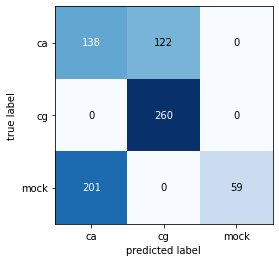

In [21]:
labels = ['ca','cg','mock']

matrix = confusion_matrix (test_labels,predicted)
plot_confusion_matrix(matrix, figsize=(4,4))
plt.xticks(range(3),labels, fontsize=10)
plt.yticks(range(3),labels, fontsize=10)